<h1>Hola muchachos y benvenido en el RECORDO LINKAGGIO<h1>
<h3>Per prima cosa dobbiamo fare il setup dell'ambiente<h3>
<h4>Nulla di complicato e se hai giá installato la libreria recordlinkage nel tuo ambiente python puoi saltare questo passaggio<h4>
<h5>Ma considera che ha anche queste dipendenze:
    numpy,
    pandas,
    scipy,
    sklearn,
    jellyfish,
    joblib,
Inoltre raccomandate sono:
    numexpr - accelerating certain numerical operations,
    bottleneck - accelerating certain types of nan evaluations<h5>


In [1]:
!pip install recordlinkage

<h2>Da qui inizia l'uso e costumo della libreria<h2>

# Record Linkage e Deduplicazione Aziende

## Introduzione  
In questo notebook, utilizziamo la libreria `recordlinkage` per identificare e unire duplicati in un dataset di aziende. Seguiremo i seguenti passaggi:  
1. **Normalizzazione dei dati**  (vedi normalize_company_name.ipynb)
2. **Blocchi per ridurre i confronti**  
3. **Confronto tra record**  
4. **Classificazione dei duplicati**  
5. **Aggregazione dei migliori dati**  

---
#### **Step 1: Importazione delle Librerie e del DataFrame**

In [1]:
import recordlinkage
from recordlinkage import Compare
from recordlinkage.preprocessing import clean
import pandas as pd

companies_df = pd.read_csv('../aziende_normalizzate.csv')

#### **Step 2: Creazione del blocco per la riduzione delle coppie candidate**

Il blocco serve a ridurre il numero di confronti tra righe, raggruppando insieme quelle che potrebbero appartenere alla stessa azienda. Per esempio, bloccheremo le righe con lo stesso nome azienda, città e paese.


In [2]:
indexer = recordlinkage.Index()
indexer.block(left_on=['company_name'])  #proviamo solo su normalizzazione

candidate_pairs = indexer.index(companies_df)

print(f'Numero di coppie candidate: {len(candidate_pairs)}')

Numero di coppie candidate: 39762


#### **Sicuramente questo metodo di blocking puó esser migliorato perché penso ci perdiamo un sacco di match peró é anche vero che se hanno questi valori uguali sicuro so uguali**
#### Le possibili migliorie sono 2 o normalizziamo meglio i nomi e poi mettiamo bloking solo su nomi, oppure non usiamo blocking ma facciamo direttamente compare usandolo come blocking
---

### **Step 3: Confronto delle Coppie Candidate**

# **Record Linkage: Calcolo delle Feature sui Candidate Pairs**
In questa sezione, calcoliamo le feature di similarità tra le coppie di aziende candidate (`candidate_pairs`) utilizzando la libreria `recordlinkage`.

## **Passaggi:**

### 1. **Creazione del MultiIndex**  
   - Convertiamo `candidate_pairs` in un `MultiIndex`, necessario per la funzione `compare.compute()`. Questo consente di identificare ogni coppia di aziende nel dataset.

### 2. **Pulizia del DataFrame**  
   - Resettiamo l'indice di `companies_df` per garantire che ogni azienda sia identificata correttamente.
   - Riempiamo i valori `NaN` con stringhe vuote per evitare errori nel confronto tra le stringhe.
   - Convertiamo la colonna `foundation_year` in formato numerico (`int`) per evitare problemi di tipo di dato durante il confronto.

### 3. **Definizione delle Funzioni di Confronto**  
   - Utilizziamo la classe `Compare()` di `recordlinkage` per definire le metriche di similarità:
     - **`numeric`** → Confronto esatto per la colonna `foundation_year` e `number_of_employees`.
     - **`string` (Jaro-Winkler)** → Utilizziamo il metodo Jaro-Winkler per confrontare le colonne `city`, `country`, `categories`, `company_status`, `website`, `sector`, `trade_name`, `company_type` e `rank`, con una soglia di similarità di 0.85.

### 4. **Esecuzione del Confronto**  
   - Applichiamo la funzione `compare.compute()` per calcolare le feature di similarità tra le coppie di aziende. Il risultato sarà una matrice di feature che indica la somiglianza tra i record.
   - Se il dataset è molto grande e si verificano problemi di memoria, è possibile suddividere il calcolo in batch più piccoli.

### 5. **Ottimizzazione e Considerazioni**  
   - Se il calcolo delle feature causa problemi di memoria, si può optare per l'elaborazione a blocchi o l'uso di strumenti come `Dask` per il calcolo parallelo.
   - È possibile anche eseguire il calcolo su più nodi di un cluster per gestire dataset di grandi dimensioni.

Con questo processo, le feature di similarità vengono calcolate per ogni coppia di aziende nel dataset, permettendo di procedere con il matching e la valutazione dei risultati.


In [3]:
candidate_pairs_index = pd.MultiIndex.from_tuples(candidate_pairs, names=['left', 'right'])

companies_df = companies_df.reset_index(drop=True)

companies_df = companies_df.fillna("")

if companies_df['foundation_year'].dtype != 'int64':
    companies_df['foundation_year'] = pd.to_numeric(companies_df['foundation_year'], errors='coerce').fillna(0).astype(int)

if companies_df['number_of_employees'].dtype != 'int64':
    companies_df['number_of_employees'] = pd.to_numeric(companies_df['number_of_employees'], errors='coerce').fillna(0).astype(int)

compare = Compare()
compare.numeric('foundation_year', 'foundation_year', label='foundation_year')
compare.string('city', 'city', method='jarowinkler', threshold=0.85, label='city')
compare.string('country', 'country', method='jarowinkler', threshold=0.85, label='country')
compare.string('categories', 'categories', method='jarowinkler', threshold=0.85, label='categories')
compare.string('company_status', 'company_status', method='jarowinkler', threshold=0.85, label='company_status')
compare.string('website', 'website', method='jarowinkler', threshold=0.85, label='website')
compare.string('sector', 'sector', method='jarowinkler', threshold=0.85, label='sector')
compare.string('trade_name', 'trade_name', method='jarowinkler', threshold=0.85, label='trade_name')
compare.string('company_type', 'company_type', method='jarowinkler', threshold=0.85, label='company_type')
compare.string('rank', 'rank', method='jarowinkler', threshold=0.85, label='rank')
compare.numeric('number_of_employees', 'number_of_employees', label='number_of_employees')


try:
    features = compare.compute(candidate_pairs_index, companies_df)
    display(features.head(10))
except Exception as e:
    print("Errore durante il calcolo delle feature sull'intero dataset:", e)

foundation_year  city  country  categories  company_status  \
left right                                                               
12   11                 1.0   0.0      1.0         0.0             0.0   
13   11                 1.0   0.0      1.0         0.0             0.0   
     12                 1.0   1.0      1.0         0.0             0.0   
14   11                 1.0   0.0      1.0         0.0             0.0   
     12                 1.0   0.0      1.0         0.0             0.0   
     13                 1.0   0.0      1.0         0.0             0.0   
22   21                 1.0   0.0      1.0         0.0             0.0   
23   21                 1.0   0.0      1.0         0.0             0.0   
     22                 1.0   0.0      1.0         0.0             0.0   
25   24                 1.0   0.0      1.0         0.0             0.0   

            website  sector  trade_name  company_type  rank  \
left right                                                    
12   11         0.0     0.0         0.0           0.0   0.0   
13   11         0.0     0.0         0.0           0.0   0.0   
     12         1.0     0.0         1.0           0.0   0.0   
14   11         0.0     0.0         0.0           0.0   0.0   
     12         0.0     0.0         0.0           0.0   0.0   
     13         0.0     0.0         0.0           0.0   0.0   
22   21         0.0     0.0         0.0           0.0   0.0   
23   21         0.0     0.0         0.0           0.0   0.0   
     22         0.0     0.0         0.0           0.0   0.0   
25   24         0.0     0.0         0.0           0.0   0.0   

            number_of_employees  
left right                       
12   11                     1.0  
13   11                     1.0  
     12                     1.0  
14   11                     1.0  
     12                     1.0  
     13                     1.0  
22   21                     1.0  
23   21                     1.0  
     22                     1.0  
25   24                     1.0


---

### **Step 4: Filtraggio delle corrispondenze**

In [5]:
matches = features[features.sum(axis=1) > 5]

print(f'Numero di corrispondenze trovate: {len(matches)}')

matches.head()

Numero di corrispondenze trovate: 215


,,foundation_year,city,country,categories,company_status,website,sector,trade_name,company_type,rank,number_of_employees
left,right,,,,,,,,,,,
13,12,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1152,1151,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1378,1377,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1380,1379,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1436,1435,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### **Step 5: Cobinazione righe**
Infine, possiamo deduplicare i dati aziendali combinando le righe corrispondenti. In questo esempio, prenderemo i valori più "affidabili" (ad esempio, il valore massimo per le colonne numeriche) per ogni gruppo di corrispondenze.

In [6]:
grouped_matches = matches.loc[matches.sum(axis=1).groupby(level=0).idxmax()]

grouped_matches.head(100)

,,foundation_year,city,country,categories,company_status,website,sector,trade_name,company_type,rank,number_of_employees
left,right,,,,,,,,,,,
13,12,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1152,1151,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1378,1377,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1380,1379,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1436,1435,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29962,29961,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
30331,30330,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
30462,30461,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


# **Ora dobbiamo mettere tutto insieme**

### Codice per deduplicazione e aggregazione dei dati

In questo codice, stiamo utilizzando le librerie **Pandas** e **NetworkX** per gestire e aggregare i dati aziendali duplicati. La libreria **NetworkX** ci permette di costruire un grafo delle connessioni tra aziende basate sui loro match, identificando i gruppi di duplicati tramite componenti connesse. Vediamo come funziona:

#### 1. **Costruzione del Grafo delle Connessioni**

NetworkX è una libreria Python utilizzata per la creazione, manipolazione e studio della struttura delle reti complesse. In questo caso, la stiamo utilizzando per costruire un grafo in cui ogni azienda è un **nodo**, e ogni coppia di aziende che fanno match è un **arco** tra di esse. Una volta costruito il grafo, possiamo utilizzare la funzione `connected_components` di NetworkX per identificare i **gruppi di aziende duplicate**. Ogni gruppo di aziende duplicate è una **componente connessa** nel grafo.

#### 2. **Assegnazione del Group ID**

Dopo aver trovato i gruppi di aziende duplicate, assegniamo un **ID unico (group_id)** a ciascun gruppo. Ogni azienda avrà associato il suo `group_id`, che verrà utilizzato per aggregare i dati.

#### 3. **Aggregazione dei Dati**

Per ciascun gruppo di duplicati, aggregheremo i dati come segue:
- **Numerici:** prendiamo il valore **massimo** (ad esempio, `foundation_year`).
- **Testo:** concatenamo i valori **unici** (ad esempio, città, paese, ecc.) separati da `" | "`.
- Rimuoviamo i valori **NaN** e manteniamo solo i valori effettivi.

#### 4. **Stampa dei Gruppi Aggregati**

Vogliamo anche stampare i gruppi che sono stati aggregati, ma solo quando il gruppo contiene **almeno 3 elementi**. Questo ci aiuta a concentrarci su quelli che potrebbero essere i gruppi più significativi o complessi.

In [7]:
import networkx as nx

def merge_values(series):
    unique_values = set(series.dropna())  
    return ' | '.join(map(str, unique_values)) if len(unique_values) > 0 else ''  

G = nx.Graph()
G.add_edges_from(grouped_matches.index.tolist())

connected_components = list(nx.connected_components(G))

duplicate_groups = {node: i for i, component in enumerate(connected_components) for node in component}

companies_df['group_id'] = companies_df.index.map(duplicate_groups)

def print_aggregated_rows(group_id, group_data):
    if len(group_data) >= 3:  
        print(f"\nAggregazione del gruppo {group_id} (con {len(group_data)} elementi):")
        group_data = group_data.reset_index()  
        print(group_data[['company_name', 'city', 'country', 'address']])  

final_df = companies_df.groupby('group_id').agg(merge_values).reset_index()

final_df = final_df.drop(columns=['group_id'])

for group_id, group_data in companies_df.groupby('group_id'):
    print_aggregated_rows(group_id, group_data)

final_df.to_csv("deduplicated_companies.csv", index=False)

display(final_df.head())



Aggregazione del gruppo 91.0 (con 4 elementi):
       company_name      city         country  \
0  heathrow airport  hounslow  united kingdom   
1  heathrow airport  hounslow  united kingdom   
2  heathrow airport  hounslow  united kingdom   
3  heathrow airport  hounslow  united kingdom   

                                             address  
0  the compass centre nelson road, london heathro...  
1  the compass centre nelson road, london heathro...  
2  the compass centre nelson road, london heathro...  
3  the compass centre nelson road, london heathro...  


,company_id,company_name,trade_name,industry,sector,categories,company_status,company_type,address,postal_code,...,emtak_code,nace_code,facebook,twitter,pinterest,instagram,investors,region,notes_or_description,modified
0,1804 | 3694,1-800-flowers.com,1-800-flowers.com,,,,,,2 jericho plz ste 200,117531681,...,,,,,,,,,headquarter,False
1,2164 | 4108,adidas promotional retail operations,adidas,,,,,,5055 n greeley ave,972173524,...,,,,,,,,,single address,False
2,4419 | 2454,adventist health system sunbelt healthcare,adventhealth,,,,,,900 hope way,327141502,...,,,,,,,,,headquarter,False
3,2451 | 4416,adventist health system/sunbelt,adventhealth,,,,,,900 hope way,327141502,...,,,,,,,,,headquarter,False
4,923 | 3764,aeffe,moschino,,,,,,via delle querce 51,47842,...,,,,,,,,,| headquarter,False


### Analisi della distribuzione dei duplicati

In questa sezione, generiamo un grafico che ci aiuta a esplorare meglio la distribuzione dei duplicati.

#### 1. **Distribuzione delle dimensioni dei gruppi di duplicati**

Abbiamo creato un istogramma per visualizzare la distribuzione delle dimensioni dei gruppi di duplicati. Ogni barra dell'istogramma rappresenta un gruppo di duplicati con una determinata dimensione, mostrando quanti gruppi hanno una dimensione specifica (escludendo i gruppi che contano solo una riga).

Abbiamo escluso i gruppi con solo una riga per concentrare l'analisi sui gruppi che presentano effettivamente duplicati, in modo da avere una visione più significativa dei dati.

#### 2. **Distribuzione dei duplicati per paese**

Un altro grafico mostra la distribuzione dei duplicati per paese, evidenziando in quale paese si concentrano maggiormente i duplicati. Questo grafico a barre ci consente di vedere quali paesi hanno un numero maggiore di duplicati e se ci sono tendenze geografiche nei dati.


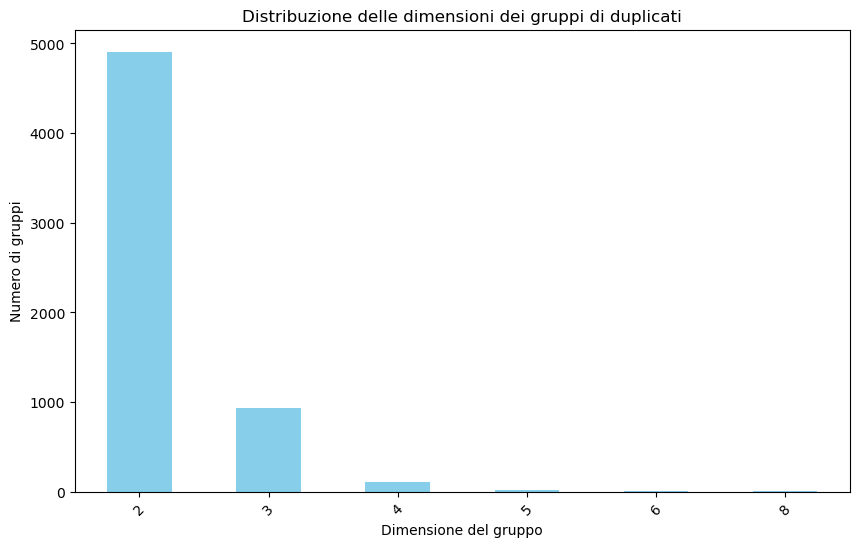

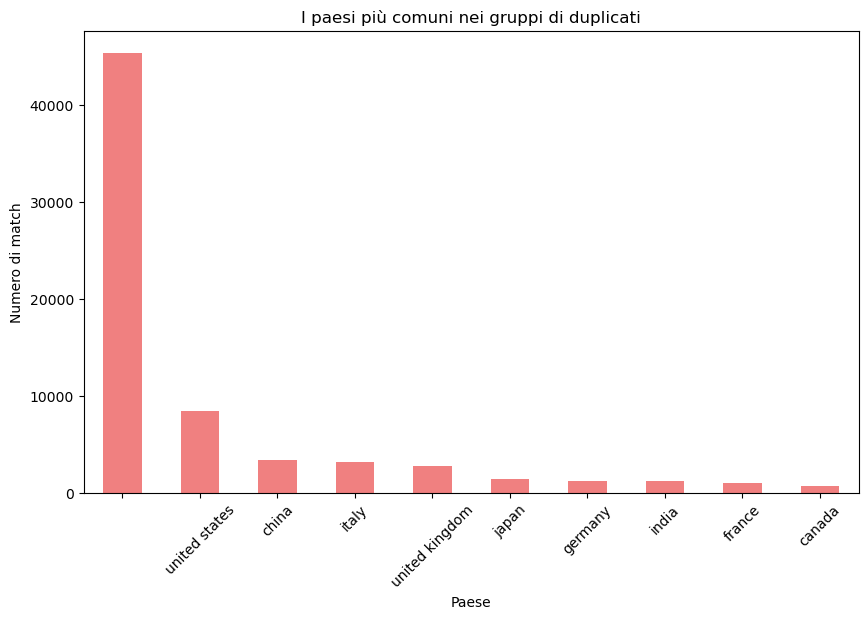

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Grafico a barre (istogramma) della distribuzione delle dimensioni dei gruppi di duplicati
group_sizes = companies_df.groupby('group_id').size()

# Escludiamo i gruppi con solo 1 elemento
group_sizes_filtered = group_sizes[group_sizes > 1]

# Creiamo l'istogramma delle dimensioni dei gruppi
plt.figure(figsize=(10, 6))
group_sizes_filtered.value_counts().sort_index().plot(kind='bar', color='skyblue')

# Aggiungiamo il titolo e le etichette
plt.title('Distribuzione delle dimensioni dei gruppi di duplicati')
plt.xlabel('Dimensione del gruppo')
plt.ylabel('Numero di gruppi')
plt.xticks(rotation=45)
plt.show()



# Paese
country_counts = companies_df['country'].value_counts()
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar', color='lightcoral')
plt.title('I paesi più comuni nei gruppi di duplicati')
plt.xlabel('Paese')
plt.ylabel('Numero di match')
plt.xticks(rotation=45)
plt.show()
